# Lab 1: Intro, BFS/DFS

To run these notebooks at home, you can either use Colab or set up your own [jupyter notebooks](https://jupyter.org/install.html) on your computer.

You are strongly encouraged to look at the python notebook if you are not so familiar with the language.

Consider a following maze. What is the shortest path to the gold in this maze? What is the order of the states explored by BFS and DFS, if the order of actions is Up, Down, Left, Right?

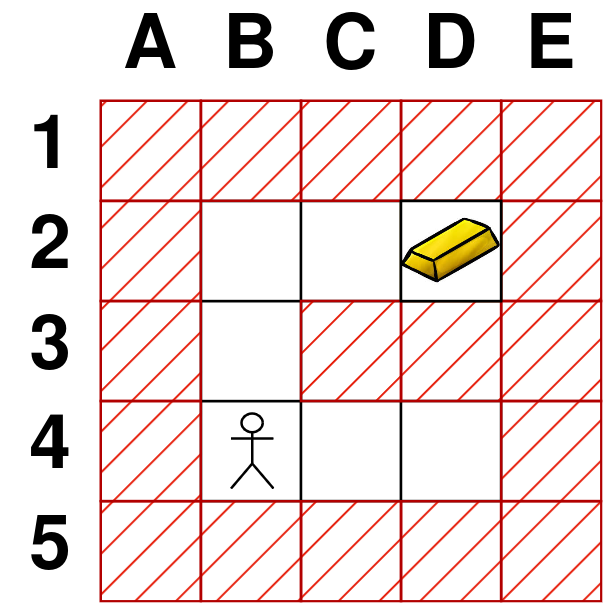



## The Grid-World Maze

We made a simple maze environment, where you can move vertically / horizontally and collect gold items. Your current position is denoted with a `@` symbol. Let's go briefly over the implementation to see what it does.

In [1]:
from collections import deque
from copy import deepcopy
from typing import List, Dict, Tuple, Set, Optional

Action = str  # Type alias


class State:
    def __init__(self, maze_rows: List[str]) -> None:
        self._maze_rows = [list(row) for row in maze_rows]

        # Make sure the maze has a rectangular shape, and has a proper boundary.
        assert all(len(row) == self.num_cols() for row in self._maze_rows)
        assert set(self._maze_rows[0]) == {"#"} and set(self._maze_rows[-1]) == {"#"}
        assert all(row[0] == "#" and row[-1] == "#" for row in self._maze_rows)

    def actions(self) -> List[Action]:
        """
        :return: list of available actions
        """
        return [
            "u",  # Up
            "d",  # Down
            "l",  # Left
            "r",  # Right
        ]

    def apply(self, action: Action) -> None:
        """
        Change current state by applying an action.
        """

        assert action in self.actions()
        i, j = self.current_position()

        # Maze rows is a List, this makes a reference in Python, not a copy.
        m = self._maze_rows

        # These bound checks work because we made sure that the whole maze is
        # delimited with char #   -- otherwise we would have to make much more
        # complicated if statements! This is a common implementation trick, used
        # for example in Chess or Go engines.
        if action == "u" and m[i - 1][j] != "#":
            m[i][j], m[i - 1][j] = " ", "@"
        elif action == "d" and m[i + 1][j] != "#":
            m[i][j], m[i + 1][j] = " ", "@"
        elif action == "l" and m[i][j - 1] != "#":
            m[i][j], m[i][j - 1] = " ", "@"
        elif action == "r" and m[i][j + 1] != "#":
            m[i][j], m[i][j + 1] = " ", "@"

    def copy(self) -> "State":
        """
        Make a copy of the current state.
        """
        return State(deepcopy(self._maze_rows))

    # -- Maze specific methods ---------------------------------------------------

    def num_rows(self) -> int:
        return len(self._maze_rows)

    def num_cols(self) -> int:
        return len(self._maze_rows[0])

    def current_position(self) -> Tuple[int, int]:
        # Find current position: it is denoted using an @ sign.
        for i in range(self.num_rows()):
            for j in range(self.num_cols()):
                if self._maze_rows[i][j] == "@":
                    return i, j
        raise RuntimeError(
            "Invalid maze: current position not found in: " + "\n".join(self._maze_rows)
        )

    def captures_gold(self, action: Action) -> bool:
        i, j = self.current_position()
        m = self._maze_rows
        return (
            (action == "u" and m[i - 1][j] == "G")
            or (action == "d" and m[i + 1][j] == "G")
            or (action == "l" and m[i][j - 1] == "G")
            or (action == "r" and m[i][j + 1] == "G")
        )

    def has_any_gold(self) -> bool:
        for i in range(self.num_rows()):
            for j in range(self.num_cols()):
                if self._maze_rows[i][j] == "G":
                    return True
        return False

    # -- Helper methods ----------------------------------------------------------

    def __str__(self) -> str:
        return "\n".join(["".join(row) for row in self._maze_rows])

    def __eq__(self, other) -> bool:
        return self._maze_rows == other._maze_rows

    def __hash__(self) -> int:
        return hash(str(self))

    def __repr__(self) -> str:
        return str(self)

Let's make the simplest valid maze example.

In [2]:
maze0 = State(["###",
               "#@#",
               "###"])
maze0

###
#@#
###

Let's try to move.


In [3]:
maze0.apply("d")
maze0

###
#@#
###

Nothing happens. It'a a boring maze after all :)

Let's make a number of more complicated mazes.


In [4]:
maze1 = State(["####",
               "#@G#",
               "####"])
maze2 = State(["#####",
               "#  G#",
               "# ###",
               "#@  #",
               "#####"])

### **Task 0**:

Apply appropriate actions to make your character to fetch the gold  for both mazes.

!! Now beware that the `.apply()` function **changes** the maze, so if we want to keep the original, we need to copy it. !!


In [5]:
# Write appropriate sequence of apply()
maze = maze1.copy()
maze.apply("r")
print(maze)

####
# @#
####


In [8]:
maze = maze2.copy()
maze.apply("u")
maze.apply("u")
maze.apply("r")
maze.apply("r")
print(maze)

#####
#  @#
# ###
#   #
#####


### **Task 1**:

Write BFS traversal to fetch the gold. Return a list of actions which need to be followed from the initial maze.

Hint: use `captures_gold(action)` to know when to terminate search.



In [9]:
def find_some_gold_bfs(init_maze: State) -> List[Action]:
    queue: deque[(State, List[Action])]= deque([(init_maze, [])])
    is_visited: set[Tuple[int, int]] = set()

    while queue:
        cur_maze: State
        cur_path: List[Action]
        cur_maze, cur_path = queue.popleft()

        cur_pos: Tuple[int, int] = cur_maze.current_position()
        if cur_pos in is_visited:
            continue
        is_visited.add(cur_pos)

        for action in cur_maze.actions():
            new_maze: State = cur_maze.copy()
            if new_maze.captures_gold(action):
                return cur_path + [action]
            new_maze.apply(action)

            if new_maze.__eq__(cur_maze):
                continue

            queue.append((new_maze, cur_path + [action]))

    return []


It is customary to write automatic tests to verify the implementation works correctly. The simplest is to use just `assert`s as checks.

You are **strongly advised** to generate your own test cases when you solve home tasks and automatically check that your algorithms solve them correctly. **Importantly** do not use BRUTE as a test server! If you have trouble getting more points for your submission, think carefully if you handle corner cases correctly, and create your own tests for them.

In [10]:
def test_maze_bfs() -> None:
    assert find_some_gold_bfs(maze1) == ["r"]
    assert find_some_gold_bfs(maze2) == ["u", "u", "r", "r"]


In [11]:
test_maze_bfs()

### Task 2

Write DFS traversal to fetch the gold. Return a list of actions which need to be followed from the initial maze.

In [12]:
def find_some_gold_dfs(init_maze: State, is_visited: set[Tuple[int, int]]) -> List[Action]:
    cur_pos: Tuple[int, int] = init_maze.current_position()
    if cur_pos in is_visited:
        return []
    is_visited.add(cur_pos)

    cur_path: List[Action] = []
    for action in init_maze.actions():
        new_maze: State = init_maze.copy()
        if new_maze.captures_gold(action):
            return [action]

        new_maze.apply(action)
        if new_maze.__eq__(init_maze):
            continue

        new_path: List[Action] = find_some_gold_dfs(new_maze, is_visited)
        cur_len: int = len(cur_path)
        new_len: int = len(new_path)
        if new_len != 0 and (cur_len == 0 or new_len < cur_len - 1):
            cur_path = [action] + new_path

    return cur_path

Add a test!

In [13]:
def test_maze_dfs() -> None:
    assert find_some_gold_dfs(maze1, set()) == ["r"]
    assert find_some_gold_dfs(maze2, set()) == ["u", "u", "r", "r"]


In [14]:
test_maze_dfs()

### Task 3

Let's make a more complicated maze:

In [15]:
maze3 = State(["########",
               "#  G#G #",
               "# # ## #",
               "#@  G  #",
               "########"])

Use your previous implementations to collect all the golds.
Hint: use `maze.has_any_gold()` to terminate the collection loop.

In [16]:
def collect_all_golds(init_maze: State) -> List[Action]:
    res_path: List[Action] = []
    cur_maze: State = init_maze.copy()
    while cur_maze.has_any_gold():
        path: List[Action] = find_some_gold_bfs(cur_maze)
        res_path += path
        for action in path:
            cur_maze.apply(action)
    return res_path

Add a test!

In [17]:
def test_maze_collect_all_gold() -> None:
    assert collect_all_golds(maze3) == ["r", "r", "r",
                                        "l", "u", "u",
                                        "d", "d", "r", "r", "r", "u", "u", "l"]


In [18]:
test_maze_collect_all_gold()

# Extra: vizualize the state space


Graphviz is a very nice library for visualizing graphs. Let's install and import:

In [19]:
# Code following bang (the ! character) runs in  shell.
!pip install graphviz

# You may need to run also system package installation in terminal.
#!sudo apt install graphviz

import graphviz

It has a simple and intuitive syntax. Like this:

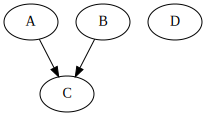

In [20]:
graph = graphviz.Digraph()
graph.edge("A", "C")
graph.edge("B", "C")
graph.node("D")
graph

The python code generated this domain-specific code for graphviz: 

In [21]:
print(graph.source)

digraph {
	A -> C
	B -> C
	D
}



You can create also multi-graphs and pass style attributes:

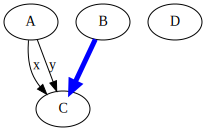

In [35]:
edge_attrs = dict(color="blue", penwidth="5")
graph = graphviz.Digraph(strict=False)
graph.edge("A", "C", label="x")
graph.edge("A", "C", label="y")
graph.edge("B", "C", **edge_attrs)
graph.node("D")
graph

Let's make a function that saves all the maze transitions. Then we can render them using graphviz

In [36]:
def maze_transitions(init_state: State) -> List[Tuple[State, Action, State]]:
    transitions = []  # List of oriented edges: (from_state, action, to_state)
    opened = []  # List of open states to go through.
    closed = []  # List of states we visited.

    opened.append(init_state)
    while len(opened) > 0:
        state = opened.pop()
        closed.append(state)
        for action in state.actions():
            next_state = state.copy()
            next_state.apply(action)
            if not next_state in closed:
                opened.append(next_state)
            transitions.append((state, action, next_state))
    return transitions


def make_graph(transitions: List[Tuple[State, Action, State]], 
               **attrs: dict) -> graphviz.Digraph:
    graph = graphviz.Digraph(
        strict=False,  # Allow multi-edges
        engine="fdp",  # Layout engine
    )
    graph.node_attr["fontname"] = "monospace"
    graph.node_attr.update(attrs)

    for from_state, action, to_state in transitions:
        graph.edge(str(from_state), str(to_state), key=action, label=action, **attrs)
    return graph

You can compose the functions together:

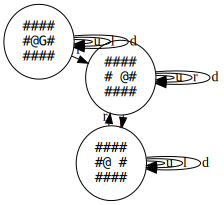

In [37]:
transitions = maze_transitions(maze1)
graph = make_graph(transitions)
graph

Let's create a generic function which adds additional edges to the graph to highlight a path from an initial maze.

In [27]:
def highlight_path(graph: graphviz.Digraph, 
                   init_state: State, 
                   path: List[Action], 
                   **edge_attrs: dict):
    from_state = init_state
    for i, action in enumerate(path):
        to_state = from_state.copy()
        to_state.apply(action)
        graph.edge(
            str(from_state), str(to_state), label=f"#{i}: {action}", **edge_attrs
        )
        from_state = to_state

We can render the maze transitions and the solutions found with your algorithm.

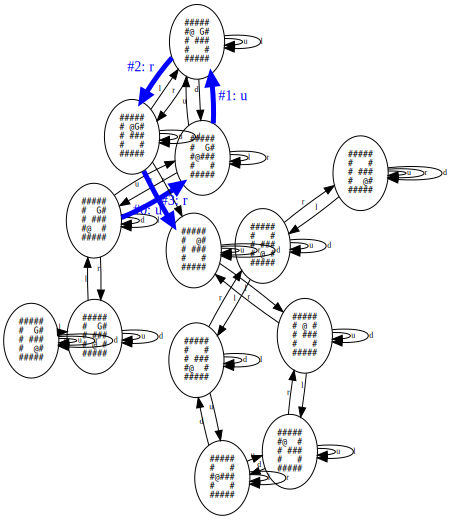

In [38]:
example_maze = maze2  # Try maze2, maze3

transitions = maze_transitions(example_maze)
full_path = collect_all_golds(example_maze)
graph = make_graph(transitions, fontsize="8")
highlight_path(graph, example_maze, full_path, fontcolor="blue", color="blue", penwidth="5")
graph